In [142]:
# Benchmark stats
import json
import pandas as pd

with open('../steer/prompt_specs.json', 'r') as f:
    bench = json.load(f)

print(f"Total tasks: {len(bench)}")
dfbench = pd.DataFrame(bench)
dfbench.groupby("smiles").count()

Total tasks: 27


,prompt,config
smiles,,
CC1=CC=C(Cl)C(C(N[C@H](C(O)=O)CNC(CN2C(C=C(F)C(C)=N3)=C3NC2=O)=O)=O)=C1F,3,3
CCN1[C@@H](COC2=CC(C(N(C3C(NC(CC3)=O)=O)C4)=O)=C4C=C2)CCCC1,10,10
CN1CCN(C2=CC=C(N(C3=NC(N(C4=CC=CC(C(C)(C)O)=N4)N(CC=C)C5=O)=C5C=N3)[H])C=C2)CC1,6,6
CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN(C(C[C@@H]6N=C(C7=CC=C(Cl)C=C7)C(C(C)=C(C)S8)=C8N9C6=NN=C9C)=O)CC5)CC4)=O)CC3)=CC=C%10)=C%10N2CC(F)(F)F)C=C1)(C)=O,8,8


In [43]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class DepthCondition:
    """Find out at which depth of the tree a condition is met."""
    def __call__(self, d):
        return self.condition_depth(d['children'][0])+1

    def hit_condition(self, d):
        "Hit condition: define what we are looking for."
        pass

    def condition_depth(self, d, i=0):
        """bfs search for reaction that matches hit condition."""
        if self.hit_condition(d):
            return i
        if 'children' in d:
            for c in d['children']:
                if 'children' in c:
                    a=self.condition_depth(c['children'][0], i+1)
                    if a != -1:
                        return a
        return -2

    def tanimoto(self, smiles1, smiles2):
        # Convert SMILES strings to RDKit molecules
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)

        # Generate Morgan fingerprints for both molecules
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)

        # Calculate Tanimoto similarity
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return tanimoto_similarity

    def analyze_routes(self, data, title=""):
        """For all routes found (and scored) in the data, find the depth at which the hit condition is met, and plot."""
        
        depth, score = [], []
        for d in data:
            depth.append(self(d))
            score.append(d['lmdata']['routescore'])

        self.df = pd.DataFrame({'depth': depth, 'score': score})
        fig, ax = plt.subplots(figsize=(10, 4))

        sns.stripplot(x='depth', y='score', data=self.df, color='black', alpha=0.5, ax=ax, jitter=True)
        ax.set_title(title)
        plt.show()

        display(self.df.groupby("depth").mean())

## Evaluations
How good is VLM at scoring synthesis routes for specified requirements.

**Note that the LLM is prompted to also analyze the reactions and assess feasibility, along with alignment with the query**

# Target

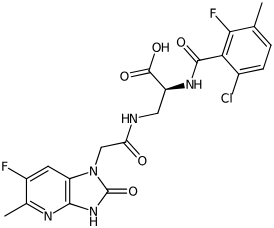

Detect `imidazole ring formation` events.

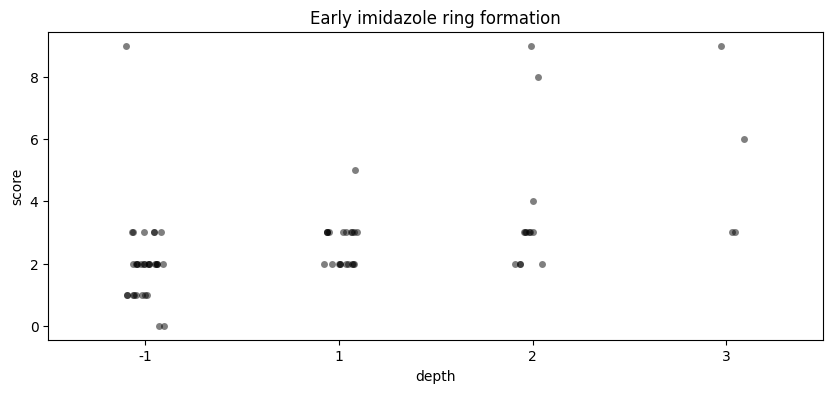

,score
depth,
-1,2.031250
1,2.619048
2,3.615385
3,5.250000


In [2]:
# change "depth" to a ratio between depth and total depth
    
        
class RingBreakDepth(DepthCondition):
    def hit_condition(self, d):
        return d.get('metadata', {}).get('policy_name') == 'ringbreaker'

with open('../steer/fullroute/Early_imidazole_ring_formation.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = RingBreakDepth()
ringbreaker_depth.analyze_routes(data, title="Early imidazole ring formation")

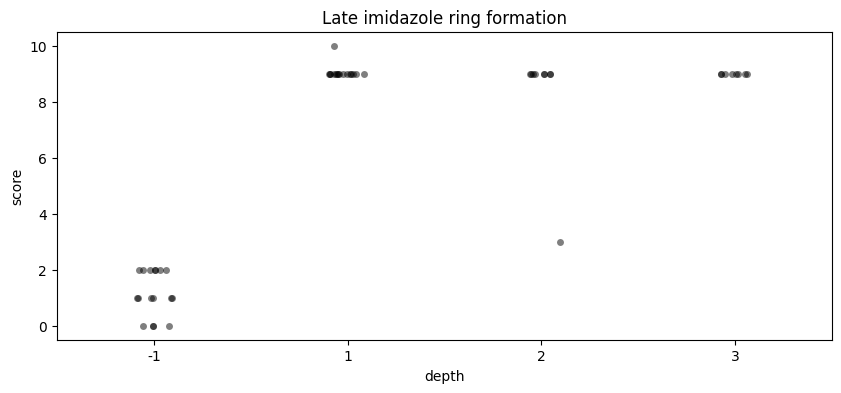

,score
depth,
-1,1.176471
1,9.062500
2,8.333333
3,9.000000


In [3]:
with open('../steer/fullroute/Late_imidazole_ring_formation.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = RingBreakDepth()
ringbreaker_depth.analyze_routes(data, title="Late imidazole ring formation")

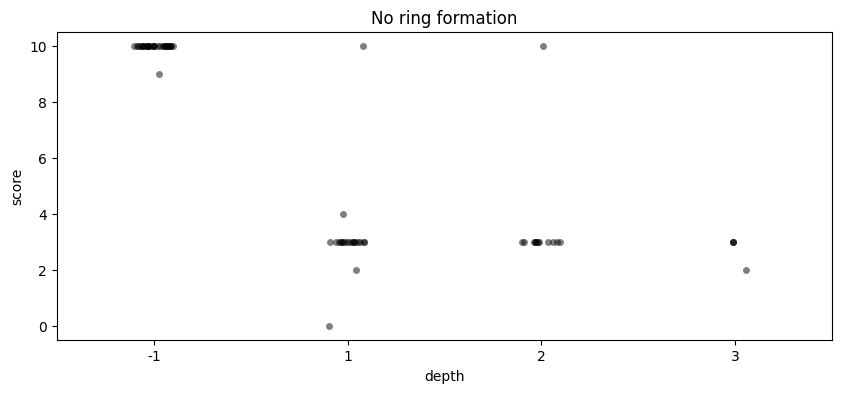

,score
depth,
-1,9.968750
1,3.190476
2,3.538462
3,2.750000


In [4]:
with open('../steer/fullroute/No_ring_formation_reaction.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = RingBreakDepth()
ringbreaker_depth.analyze_routes(data, title="No ring formation")

## Target 
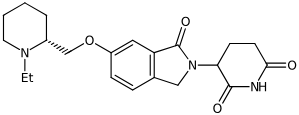

Detect breaking events of `piperidine-2,6-dione`, `oxoisoinidoline`, `piperidine`.

In [5]:
from rdkit import Chem


class MultiRxnCondBase:
    def __call__(self, d):
        return self.condition_depth(d['children'][0])

    def detect_piperidine(self, rxn):
        oxoisoindolinone = "C1CN[CH2]CC1"
        return self.detect_specific_break(rxn, oxoisoindolinone)

    def detect_oxoisoindolinone(self, rxn):
        oxoisoindolinone = "c1cC(=O)NC1"
        return self.detect_specific_break(rxn, oxoisoindolinone)

    def detect_pipe26diox(self, rxn):
        pipe26diox = "NC1CCC(=O)NC1=O"
        return self.detect_specific_break(rxn, pipe26diox)

    def detect_specific_break(self, rxn, pattern):
        p = Chem.MolFromSmarts(pattern)
        prod = Chem.MolFromSmiles(rxn.split('>>')[0])
        reac = Chem.MolFromSmiles(rxn.split('>>')[1])
        return prod.HasSubstructMatch(p) and not reac.HasSubstructMatch(p)

    def get_rxns(self, d):
        def _extract_reactions(d):
            if 'metadata' in d:
                yield d['metadata']['mapped_reaction_smiles']
                for c in d['children']:
                    if 'children' in c:
                        for r in _extract_reactions(c['children'][0]):
                            yield r
        reactions = list(_extract_reactions(d))
        return reactions

    def analyze_routes(self, data, title=""):
        """For all routes found (and scored) in the data, find the depth at which the hit condition is met, and plot."""
        
        conds, lengths, score = [], [], []
        for d in data:
            cond, length = self(d)
            conds.append(cond)
            lengths.append(length)
            score.append(d['lmdata']['routescore'])

        condvar = "Is condition met?"
        self.df = pd.DataFrame({condvar: conds, 'score': score, 'route length': lengths})
        fig, ax = plt.subplots(
            1, 2, figsize=(10, 4),
            gridspec_kw={
                'width_ratios': [5, 1],
                'wspace': 0.01,
            },
            sharey=True,
        )

        sns.stripplot(
            x='route length', y='score', 
            hue=condvar, palette='magma',
            data=self.df, ax=ax[0], jitter=True,
            alpha=0.7,
        )
        ax[0].set_title(title)

        sns.stripplot(
            data = self.df,
            x = "Is condition met?",
            y = "score",
            ax=ax[1],
        )
        plt.show()

        display(self.df.groupby("Is condition met?").mean())

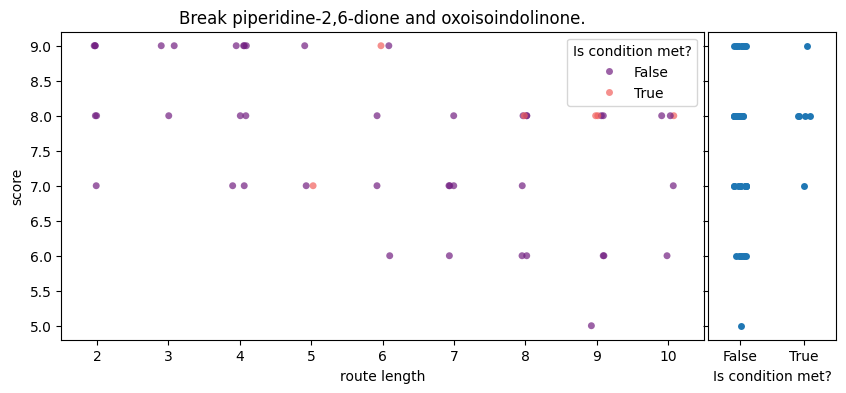

,score,route length
Is condition met?,,
False,7.627907,5.930233
True,8.000000,7.833333


In [6]:
with open('../steer/fullroute/Form_piperidine-2,6-dione_and_oxoisoindolinone_rings_in_the_retrosynthesis._Get_the_piperidine_ring_.json', 'r') as f:
    data = json.load(f)

class MultiRxnCond(MultiRxnCondBase):
    def condition_depth(self, d):
        """Extract all the reactions from tree, and find if condition is met."""
        reactions = self.get_rxns(d)

        oxo = any(self.detect_oxoisoindolinone(r) for r in reactions)
        pipe26 = any(self.detect_pipe26diox(r) for r in reactions)
        pip = any(self.detect_piperidine(r) for r in reactions)
        return (oxo and pipe26) and (not pip), len(reactions)

ringbreaker_depth = MultiRxnCond()
ringbreaker_depth.analyze_routes(data, title="Break piperidine-2,6-dione and oxoisoindolinone.")

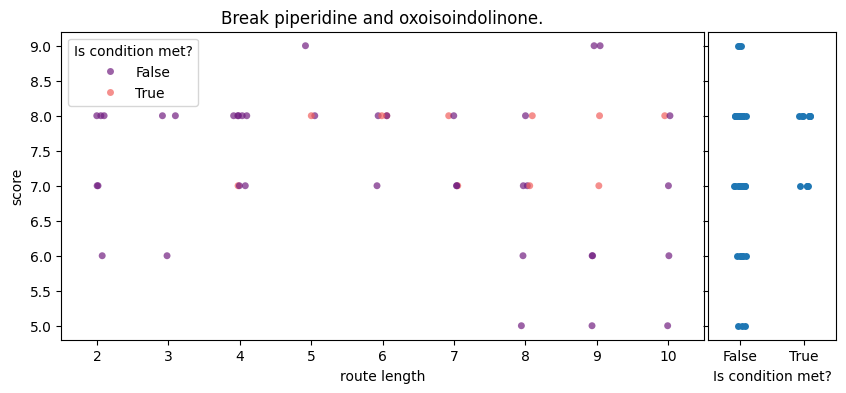

,score,route length
Is condition met?,,
False,7.263158,5.868421
True,7.636364,7.181818


In [8]:
with open('../steer/fullroute/Form_piperidine_and_oxoisoindolinone_rings_in_the_synthesis._Get_the_piperidine-2,6-dione_from_comme.json', 'r') as f:
    data = json.load(f)

class MultiRxnCond_single(MultiRxnCondBase):
    def condition_depth(self, d):
        """Extract all the reactions from tree, and find if condition is met."""
        reactions = self.get_rxns(d)

        oxo = any(self.detect_oxoisoindolinone(r) for r in reactions)
        pipe26 = any(self.detect_pipe26diox(r) for r in reactions)
        pip = any(self.detect_piperidine(r) for r in reactions)
        return (oxo and pip) and (not pipe26), len(reactions)

ringbreaker_depth = MultiRxnCond_single()
ringbreaker_depth.analyze_routes(data, title="Break piperidine and oxoisoindolinone.")

## There seem to be a better separation here.

Not sure what's going on, we would need to look closer at the LLM's response to see why it's doing this.

In general the problem doesn't seem to be low ranking of true positives, but rather that it's also ranking highly some false negatives.

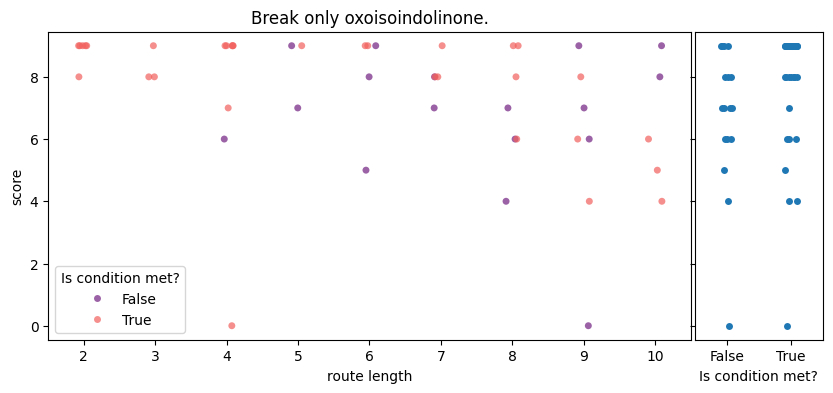

,score,route length
Is condition met?,,
False,6.764706,7.411765
True,7.718750,5.500000


In [9]:
with open('../steer/fullroute/Form_only_oxoisoindolinone_ring_in_synthesis._Get_piperidine-2,6-dione_and_piperidine_rings_from_com.json', 'r') as f:
    data = json.load(f)

class MultiRxnCond_single(MultiRxnCondBase):
    def condition_depth(self, d):
        """Extract all the reactions from tree, and find if condition is met."""
        reactions = self.get_rxns(d)

        oxo = any(self.detect_oxoisoindolinone(r) for r in reactions)
        pipe26 = any(self.detect_pipe26diox(r) for r in reactions)
        pip = any(self.detect_piperidine(r) for r in reactions)
        return (oxo) and (not pipe26) and (not pip), len(reactions)

ringbreaker_depth = MultiRxnCond_single()
ringbreaker_depth.analyze_routes(data, title="Break only oxoisoindolinone.")

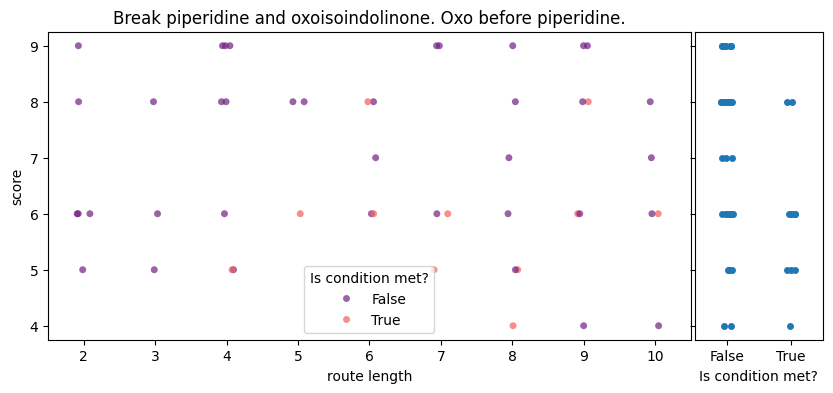

,score,route length
Is condition met?,,
False,7.105263,5.868421
True,5.909091,7.181818


In [10]:
with open('../steer/fullroute/Form_piperidine_and_oxoisoindolinone_rings_in_the_synthesis._Make_sure_that_oxoisoindolinone_is_crea.json', 'r') as f:
    data = json.load(f)

class MultiRxnCond_single(MultiRxnCondBase):
    def condition_depth(self, d):
        """Extract all the reactions from tree, and find if condition is met."""
        reactions = self.get_rxns(d)

        oxo = any(self.detect_oxoisoindolinone(r) for r in reactions)
        pipe26 = any(self.detect_pipe26diox(r) for r in reactions)
        pip = any(self.detect_piperidine(r) for r in reactions)
        return (oxo and pip) and (not pipe26), len(reactions)

ringbreaker_depth = MultiRxnCond_single()
ringbreaker_depth.analyze_routes(data, title="Break piperidine and oxoisoindolinone. Oxo before piperidine.")

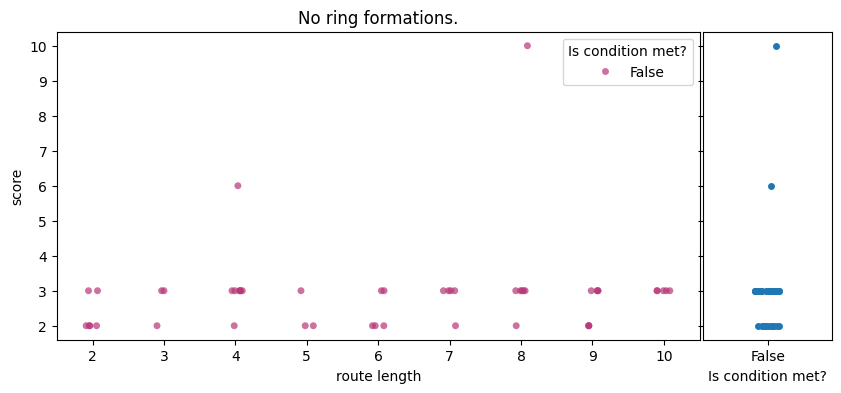

,score,route length
Is condition met?,,
False,2.877551,6.163265


In [11]:
with open('../steer/fullroute/Find_routes_with_no_ring_formations..json', 'r') as f:
    data = json.load(f)

class MultiRxnCond_single(MultiRxnCondBase):
    def condition_depth(self, d):
        """Extract all the reactions from tree, and find if condition is met."""
        reactions = self.get_rxns(d)

        oxo = any(self.detect_oxoisoindolinone(r) for r in reactions)
        pipe26 = any(self.detect_pipe26diox(r) for r in reactions)
        pip = any(self.detect_piperidine(r) for r in reactions)
        return (not oxo) and (not pip) and (not pipe26), len(reactions)

ringbreaker_depth = MultiRxnCond_single()
ringbreaker_depth.analyze_routes(data, title="No ring formations.")

### Fair for this. None of the routes are without ring breaking.

At least the model ranks them low. Now, there are some interesting routes with score of 10 or 9?

Checking the LLM output, the LLM simply failed.

## Target 
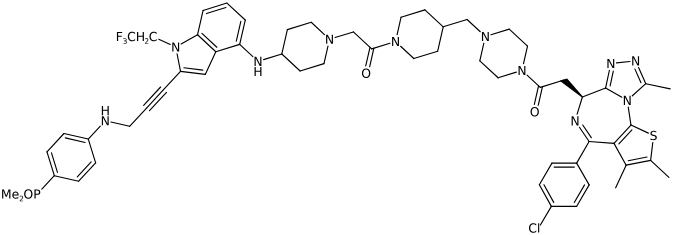

Queries:
- [x] Cut into 2 intermediates of similar size.
    - One contains `piperidine` `indole` and `aniline`.
    - The other contains `tiophenol`, `chlorobenzene`, `diazepine`, `triazole`, `piperazine`, and another `piperidine`.
- [x] Cut into 2 intermediates of similar size.
    - Disconnection made between two `piperidine` rings.
- Cut into 2 intermediates of similar size.
    - Disconnection between `piperazine` and `piperidine`.
- [x] Cut into 2 intermediates of similar size.
    - Disconnection between `diazepine` and `piperazine`.
- Key disconnection made between `indole` and `amino-piperidine` rings.

In [101]:
class ComplexQ(DepthCondition):

    def hit_condition(self, d):
        # Here, the question is when the piperidine rings become two separate molecules.
        ring1 = 29 # N29
        ring2 = 33 # N33

        rxn = d['metadata']['mapped_reaction_smiles'].split(">>")
        prod = Chem.MolFromSmiles(rxn[0])
        reacts = [Chem.MolFromSmiles(r) for r in rxn[1].split(".")]

        if (ring1 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]) and (ring2 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]):
            for r in reacts:
                if (ring1 in [a.GetAtomMapNum() for a in r.GetAtoms()]) ^ (ring2 in [a.GetAtomMapNum() for a in r.GetAtoms()]):
                    return True
        return False

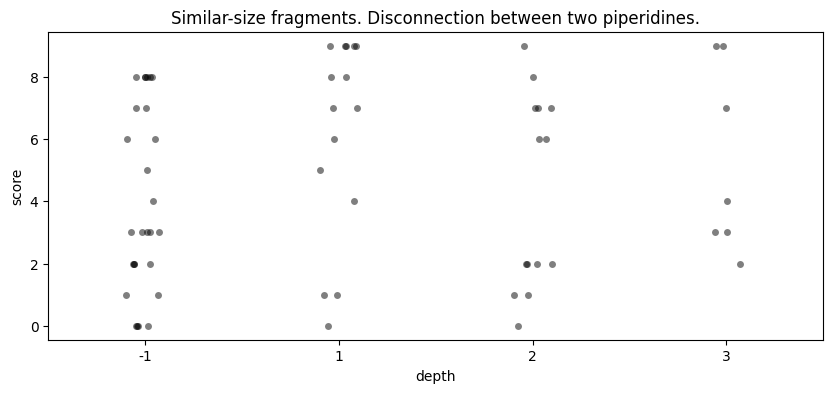

,score
depth,
-1,4.000000
1,6.133333
2,4.285714
3,5.285714


In [102]:
# 0...9 apply, 17...22. 25, 28, 29, 30, 32
with open('../steer/fullroute_no_feasibility/Identify_the_disconnection_strategy_that_will_cut_the_molecule_in_two_similarly_sized_intermediates._The_disconnection_should_be_made_between_two_pipe.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = ComplexQ()
ringbreaker_depth.analyze_routes(data, title="Similar-size fragments. Disconnection between two piperidines.")

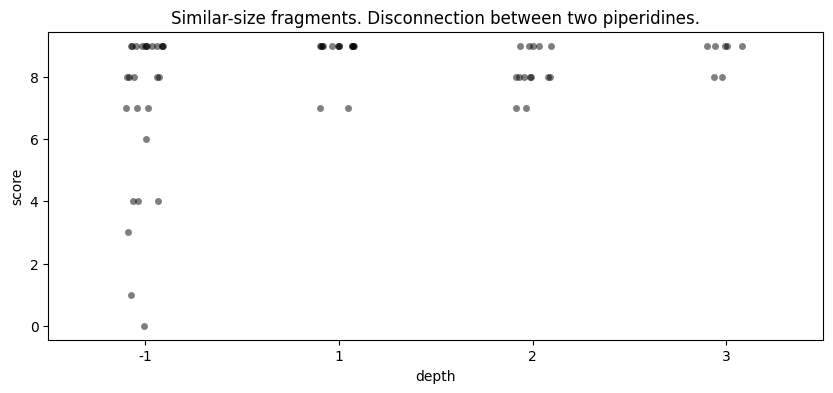

,score
depth,
-1,7.074074
1,8.733333
2,8.214286
3,8.714286


In [105]:
with open('../steer/fullroute_no_feasibility/Identify_the_disconnection_strategy_that_will_cut_the_molecule_in_two_similarly_sized_intermediates._One_intermediate_will_have_piperidine,_indole_and.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = ComplexQ()
ringbreaker_depth.analyze_routes(data, title="Similar-size fragments. Disconnection between two piperidines.")

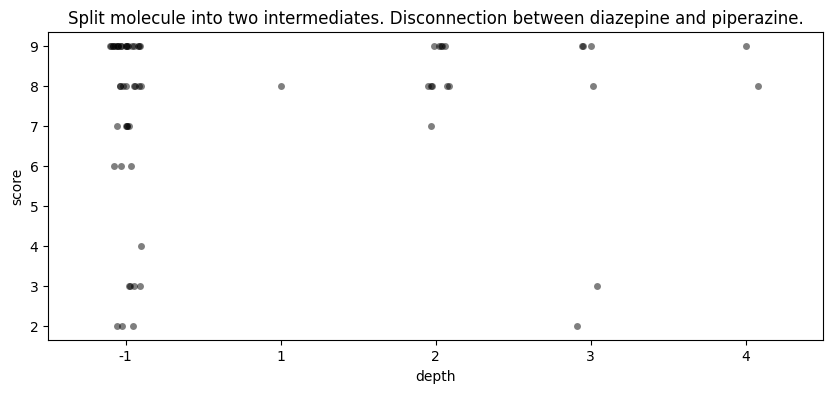

,score
depth,
-1,7.209302
1,8.000000
2,8.363636
3,6.666667
4,8.500000


In [130]:
class ComplexQ(DepthCondition):

    def hit_condition(self, d):
        # Here, the question is when the piperidine rings become two separate molecules.
        ring1 = 17 # C17
        ring2 = 21 # N21

        rxn = d['metadata']['mapped_reaction_smiles'].split(">>")
        prod = Chem.MolFromSmiles(rxn[0])
        reacts = [Chem.MolFromSmiles(r) for r in rxn[1].split(".")]

        if (ring1 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]) and (ring2 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]):
            for r in reacts:
                if (ring1 in [a.GetAtomMapNum() for a in r.GetAtoms()]) ^ (ring2 in [a.GetAtomMapNum() for a in r.GetAtoms()]):
                    return True
        return False

with open('../steer/fullroute_no_feasibility/Identify_the_disconnection_strategy_that_will_cut_the_molecule_in_two_intermediates._The_disconnection_should_be_made_between_diazepine_and_piperazine.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = ComplexQ()
ringbreaker_depth.analyze_routes(data, title="Split molecule into two intermediates. Disconnection between diazepine and piperazine.")

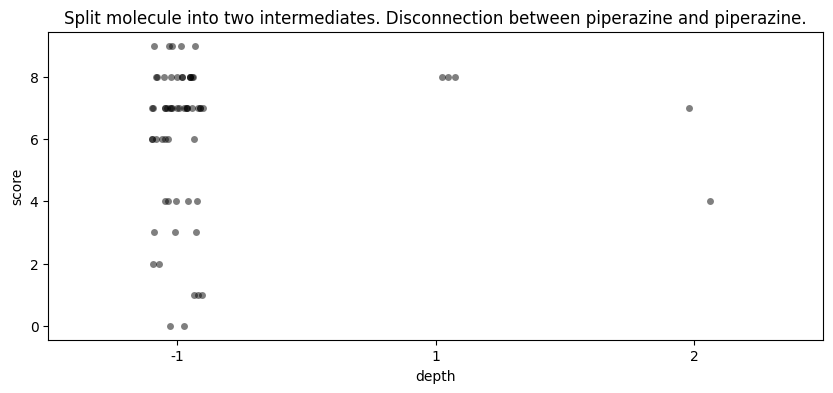

,score
depth,
-1,6.068966
1,8.000000
2,5.500000


In [132]:
class ComplexQ(DepthCondition):

    def hit_condition(self, d):
        # Here, the question is when the piperidine rings become two separate molecules.
        ring1 = 24 # N24
        ring2 = 26 # C26

        rxn = d['metadata']['mapped_reaction_smiles'].split(">>")
        prod = Chem.MolFromSmiles(rxn[0])
        reacts = [Chem.MolFromSmiles(r) for r in rxn[1].split(".")]

        if (ring1 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]) and (ring2 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]):
            for r in reacts:
                if (ring1 in [a.GetAtomMapNum() for a in r.GetAtoms()]) ^ (ring2 in [a.GetAtomMapNum() for a in r.GetAtoms()]):
                    return True
        return False

with open('../steer/fullroute_no_feasibility/Identify_the_disconnection_strategy_that_will_cut_the_molecule_in_two_similarly_sized_intermediates._The_disconnection_should_be_made_between_piperazi.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = ComplexQ()
ringbreaker_depth.analyze_routes(data, title="Split molecule into two intermediates. Disconnection between piperazine and piperazine.")

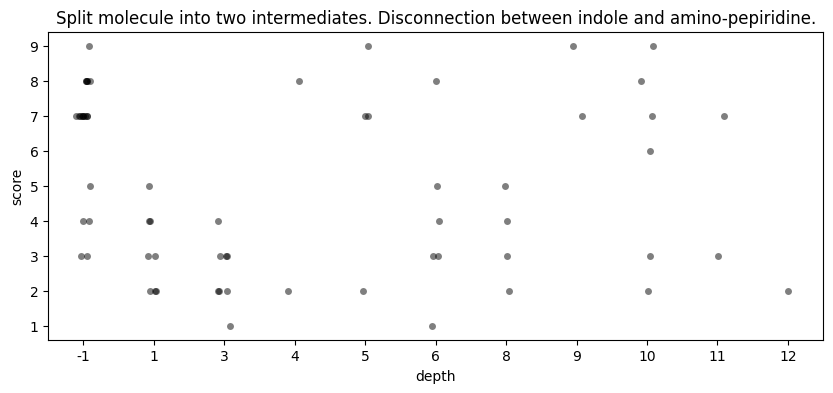

,score
depth,
-1,6.550000
1,3.125000
3,2.500000
4,5.000000
5,6.250000
6,4.000000
8,3.500000
9,8.000000
10,5.833333


In [134]:
class ComplexQ(DepthCondition):

    def hit_condition(self, d):
        # Here, the question is when the piperidine rings become two separate molecules.
        ring1 = 36 # C36
        ring2 = 38 # C38

        rxn = d['metadata']['mapped_reaction_smiles'].split(">>")
        prod = Chem.MolFromSmiles(rxn[0])
        reacts = [Chem.MolFromSmiles(r) for r in rxn[1].split(".")]

        if (ring1 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]) and (ring2 in  [a.GetAtomMapNum() for a in prod.GetAtoms()]):
            for r in reacts:
                if (ring1 in [a.GetAtomMapNum() for a in r.GetAtoms()]) ^ (ring2 in [a.GetAtomMapNum() for a in r.GetAtoms()]):
                    return True
        return False

with open('../steer/fullroute_no_feasibility/Identify_the_disconnection_strategy_where_the_key_disconnection_will_be_made_between_indole_and_amino-piperidine_rings.json', 'r') as f:
    data = json.load(f)

ringbreaker_depth = ComplexQ()
ringbreaker_depth.analyze_routes(data, title="Split molecule into two intermediates. Disconnection between indole and amino-pepiridine.")

In [138]:
ringbreaker_depth.df[ringbreaker_depth.df['depth'] == 5]

,depth,score
2,5,9.0
15,5,7.0
16,5,7.0
55,5,2.0
